In [5]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
# define constants
# output parameters
y_names = ['energy_high', 'energy_low']

# input parameters
x_names = ['iload_ratio', 'rgoff', 'rgon', 't_dead', 'vsup_ratio', 'I_DSS', 'R_DS_on', 'R_G', 'C_ISS', 'C_OSS', 'C_RSS', 'Q_G', 'Q_GD', 'Q_GS']

# seed for replication
seed = 13

In [7]:
# loading data
transistor_names = ['GS66516T', 'GS66502B', 'GS66508T', 'GS66504B', 'GS66506T']
df_raw = pd.concat([pd.read_csv(f'./data/{name}_test.csv', sep=';')[x_names + y_names] for name in transistor_names], axis=0)

# filter data for energies higher than 10nJ and smaller than 500uJ
df = df_raw[(df_raw.energy_high < 500e-6) & (df_raw.energy_high > 10e-9) & (df_raw.energy_low < 500e-6) & (df_raw.energy_low > 10e-9)].dropna()

In [8]:
# create scaler and scale data, take the log of the data to assume a gaussian curve for one side shifted data -> better learning with gaussian curve because same shape like weight function
x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(df[x_names].values)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(np.log10(df[y_names].values))

In [9]:
# split data in train and test data and save as df 
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, random_state=seed)

df_x_test = pd.DataFrame(x_scaler.inverse_transform(x_test), columns=x_names)
df_y_test = pd.DataFrame(10**y_scaler.inverse_transform(y_test), columns=y_names)
df_x_train = pd.DataFrame(x_scaler.inverse_transform(x_train), columns=x_names)
df_y_train = pd.DataFrame(10**y_scaler.inverse_transform(y_train), columns=y_names)

In [10]:
# create net and set hyper parameters
mlp = MLPRegressor(hidden_layer_sizes=(64, 128, 64, 32), max_iter=1000, alpha=0.0001, solver='adam', activation='relu',
                    random_state=seed, batch_size=32, tol=1e-6, n_iter_no_change=100, early_stopping=True, verbose= False)

# train neural net
_ = mlp.fit(x_train, y_train)

In [11]:

# write function to put in real values 
def predict(df:pd.DataFrame):
    x_scaled_pred = x_scaler.transform(df[x_names].values)
    y_scaled_pred = mlp.predict(x_scaled_pred)
    y = 10**y_scaler.inverse_transform(y_scaled_pred)
    return pd.DataFrame(y, columns=y_names)

In [12]:
# predict solution
df_y_pred = predict(df_x_test)

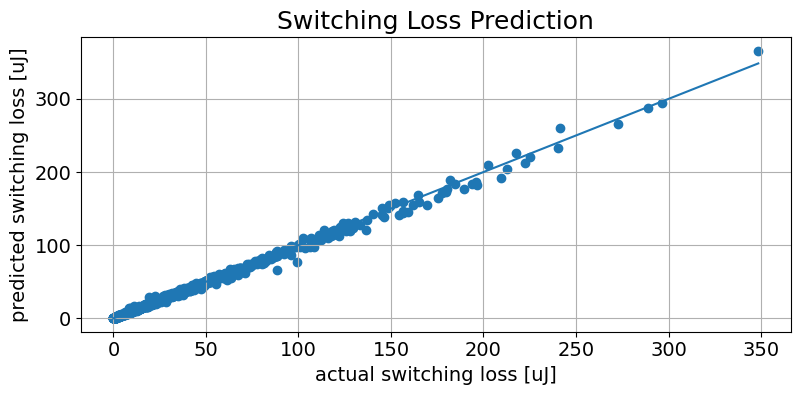

In [28]:
# plot prediction
# plt.scatter(np.log10(y_scaler.inverse_transform(y_test)*1e6), np.log10(y_scaler.inverse_transform(y_pred)*1e6))
plt.figure(figsize=(8, 4))  # Set the figure size (width, height) in inches

plt.scatter(df_y_test[y_names[0]] * 1e6, df_y_pred[y_names[0]] * 1e6)
plt.plot(np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10),np.linspace(0, max(df_y_test[y_names[0]]*1e6), 10))
plt.xlabel('actual switching loss [uJ]', fontsize=14)  # Adjust font size
plt.ylabel('predicted switching loss [uJ]', fontsize=14)  # Adjust font size
plt.title('Switching Loss Prediction', fontsize=18)
plt.tight_layout()
plt.grid()

# Adjust tick label size
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.show()


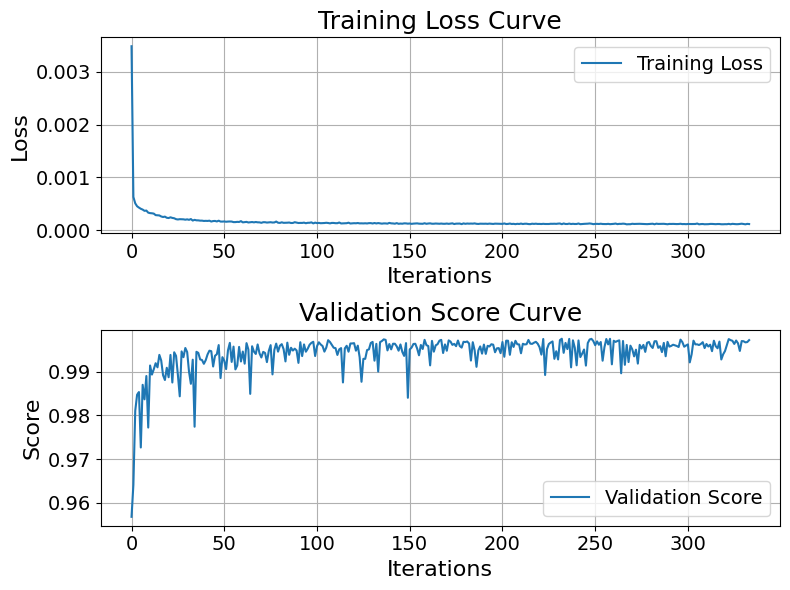

In [25]:
# Create a figure and two subplots with a specific size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # Set the figure size (width, height) in inches

# Plotting the training loss
ax1.plot(range(mlp.n_iter_), mlp.loss_curve_, label='Training Loss')
ax1.set_xlabel('Iterations', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Training Loss Curve', fontsize=18)
ax1.legend(fontsize=14)  # Increase legend font size
ax1.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label size
ax1.grid()

# Plotting the validation score
ax2.plot(range(mlp.n_iter_), mlp.validation_scores_, label='Validation Score')
ax2.set_xlabel('Iterations', fontsize=16)
ax2.set_ylabel('Score', fontsize=16)
ax2.set_title('Validation Score Curve', fontsize=18)
ax2.legend(fontsize=14)  # Increase legend font size
ax2.tick_params(axis='both', which='major', labelsize=14)  # Adjust tick label size
ax2.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
# accuracy of test values
df_y = predict(df_x_test)
df_test_loss = (abs(df_y - df_y_test)/df_y_test)*100
df_test_loss.describe()

energy_high   energy_low
count  2427.000000  2427.000000
mean      4.457109     5.715347
std       6.838232    10.680139
min       0.004885     0.003094
25%       1.322816     1.674552
50%       2.870752     3.752325
75%       5.124857     6.910823
max     148.319361   340.295381

test and trainig values got nearly same prediction error, which says that the prediction of the test values is accurate

In [16]:
# error in percent of trainig values
df_y = predict(df_x_train)
df_train_loss = (abs(df_y - df_y_train)/df_y_train)*100
df_train_loss.describe()

energy_high    energy_low
count  21843.000000  21843.000000
mean       4.332549      5.300050
std        6.877572      7.621504
min        0.000009      0.000108
25%        1.318596      1.701000
50%        2.826240      3.609173
75%        5.074247      6.646813
max      193.016909    349.982195

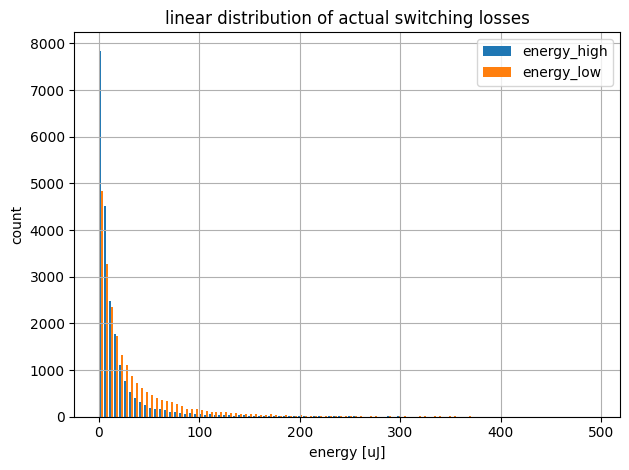

In [17]:
plt.hist(df_y_train*1e6, bins=100, label=['energy_high', 'energy_low'])
plt.xlabel('energy [uJ]')
plt.ylabel('count')
plt.title('linear distribution of actual switching losses')
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

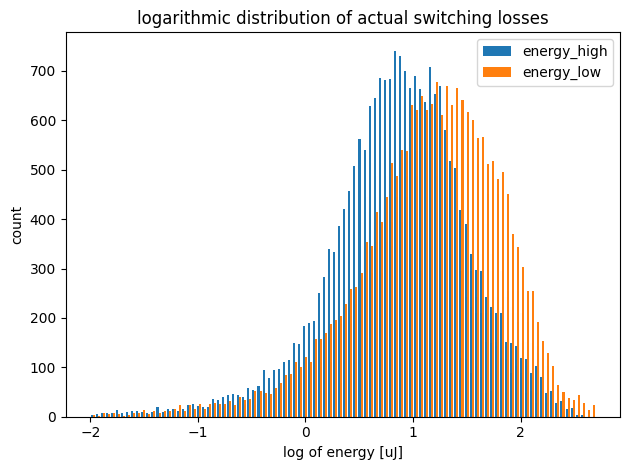

In [18]:
# better partion of the trainig data (more like gaussian curve)
plt.hist(np.log10(df_y_train*1e6), bins=100, label=['energy_high', 'energy_low'])
plt.xlabel('log of energy [uJ]')
plt.ylabel('count')
plt.title('logarithmic distribution of actual switching losses')
plt.tight_layout()
plt.legend()
plt.show()

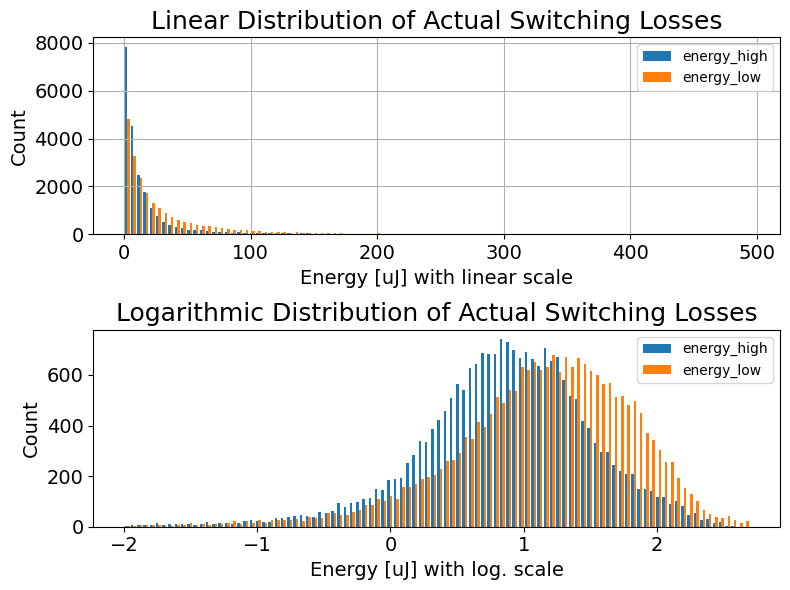

In [31]:
# Create a figure and subplots with a specific size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # Set the figure size (width, height) in inches

# First subplot: Histogram linear distribution
ax1.hist(df_y_train*1e6, bins=100, label=['energy_high', 'energy_low'])
ax1.set_xlabel('Energy [uJ] with linear scale', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Linear Distribution of Actual Switching Losses', fontsize=18)
ax1.grid()
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend()

# Second subplot: Histogram logarithmic distribution
ax2.hist(np.log10(df_y_train*1e6), bins=100, label=['energy_high', 'energy_low'])
ax2.set_xlabel('Energy [uJ] with log. scale', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_title('Logarithmic Distribution of Actual Switching Losses', fontsize=18)

ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


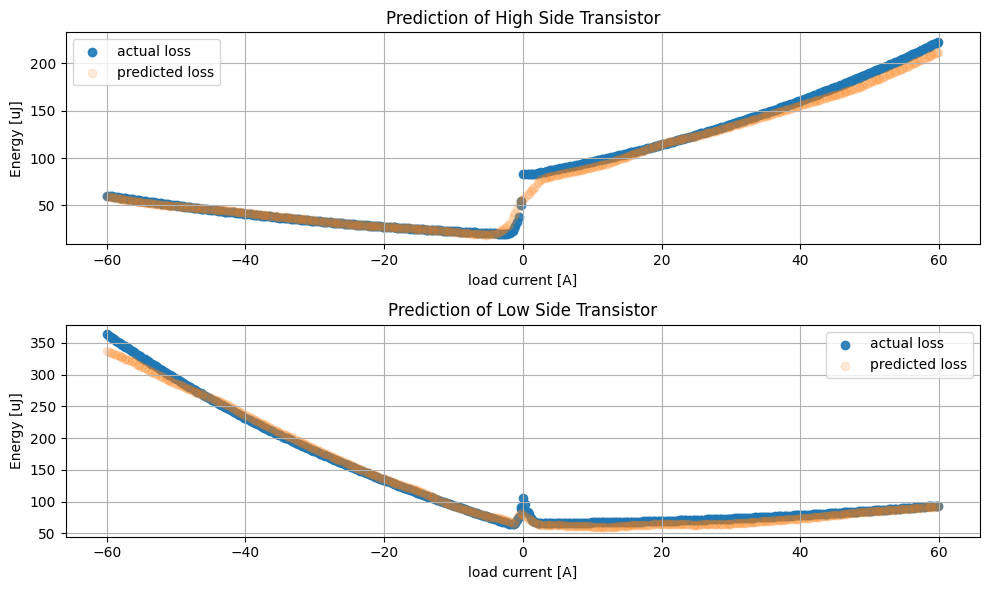

In [19]:
# plot energy over current and predict the curve as well
df_raw_energy = pd.read_csv(f'./data/GS66516T_onlyI.csv', sep=';')[x_names + y_names]

# filter data for energies higher than 10nJ and smaller than 500uJ
df_energy = df_raw_energy[(df_raw_energy.energy_high < 500e-6) & (df_raw_energy.energy_high > 10e-9) & (df_raw_energy.energy_low < 500e-6) & (df_raw_energy.energy_low > 10e-9)].dropna()

df_pred_energy = predict(df_energy[x_names])


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(10,6)

ax1.grid()
ax1.scatter(df_energy['iload_ratio']*60, df_energy['energy_high']*1e6, label='actual loss', alpha=.9)
ax1.scatter(df_energy['iload_ratio']*60, df_pred_energy['energy_high']*1e6, label='predicted loss', alpha=.15)
ax1.set_ylabel('Energy [uJ]')
ax1.set_xlabel('load current [A]')
ax1.set_title('Prediction of High Side Transistor')
ax1.legend()


ax2.grid()
ax2.scatter(df_energy['iload_ratio']*60, df_energy['energy_low']*1e6, label='actual loss', alpha=.9)
ax2.scatter(df_energy['iload_ratio']*60, df_pred_energy['energy_low']*1e6, label='predicted loss', alpha=.15)
ax2.set_ylabel('Energy [uJ]')
ax2.set_xlabel('load current [A]')
ax2.set_title('Prediction of Low Side Transistor')
ax2.legend()


plt.tight_layout()
fig.show()


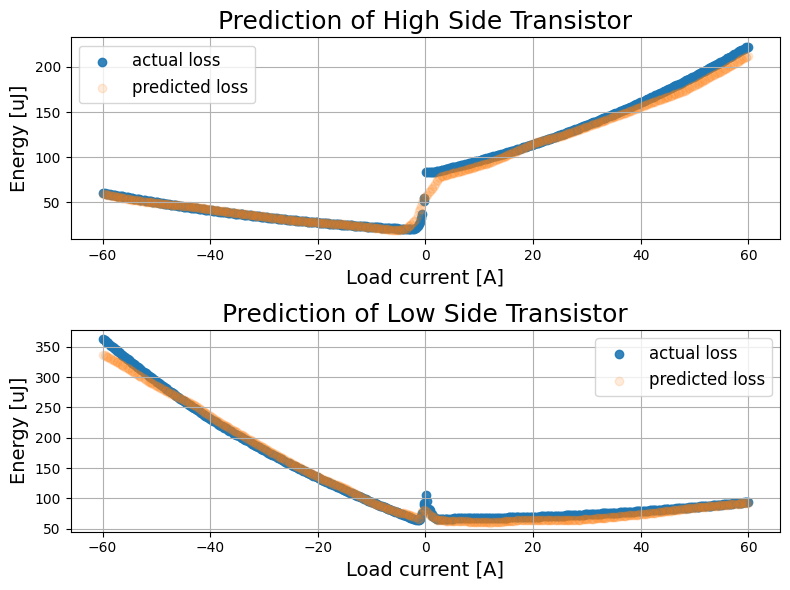

In [35]:
# Read data
df_raw_energy = pd.read_csv(f'./data/GS66516T_onlyI.csv', sep=';')[x_names + y_names]

# filter data for energies higher than 10nJ and smaller than 500uJ
df_energy = df_raw_energy[(df_raw_energy.energy_high < 500e-6) & (df_raw_energy.energy_high > 10e-9) & (df_raw_energy.energy_low < 500e-6) & (df_raw_energy.energy_low > 10e-9)].dropna()

df_pred_energy = predict(df_energy[x_names])

# Create figure and subplots with the same size settings
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot for High Side Transistor
ax1.grid()
ax1.scatter(df_energy['iload_ratio']*60, df_energy['energy_high']*1e6, label='actual loss', alpha=.9)
ax1.scatter(df_energy['iload_ratio']*60, df_pred_energy['energy_high']*1e6, label='predicted loss', alpha=.15)
ax1.set_ylabel('Energy [uJ]', fontsize=14)
ax1.set_xlabel('Load current [A]', fontsize=14)
ax1.set_title('Prediction of High Side Transistor', fontsize=18)
ax1.legend(fontsize=12)

# Plot for Low Side Transistor
ax2.grid()
ax2.scatter(df_energy['iload_ratio']*60, df_energy['energy_low']*1e6, label='actual loss', alpha=.9)
ax2.scatter(df_energy['iload_ratio']*60, df_pred_energy['energy_low']*1e6, label='predicted loss', alpha=.15)
ax2.set_ylabel('Energy [uJ]', fontsize=14)
ax2.set_xlabel('Load current [A]', fontsize=14)
ax2.set_title('Prediction of Low Side Transistor', fontsize=18)
ax2.legend(fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

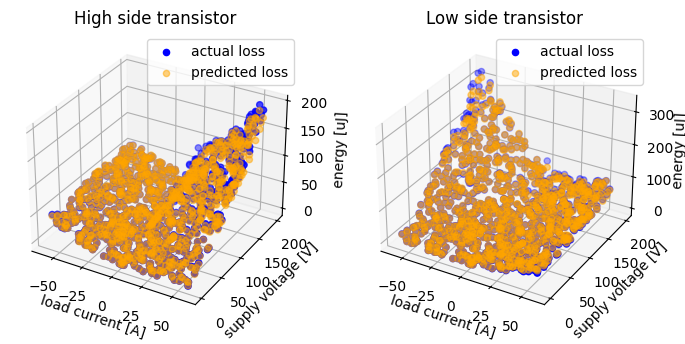

In [45]:
# plot energy over current and predict the curve as well
df_raw_VI = pd.read_csv(f'./data/GS66516T_onlyVandI.csv', sep=';')[x_names + y_names]

# filter data for energies higher than 10nJ and smaller than 500uJ
df_VI = df_raw_VI[(df_raw_VI.energy_high < 500e-6) & (df_raw_VI.energy_high > 10e-9) & (df_raw_VI.energy_low < 500e-6) & (df_raw_VI.energy_low > 10e-9)].dropna()

df_pred_VI = predict(df_VI[x_names])

# Erstelle eine Figur mit zwei Subplots
fig = plt.figure(figsize=(8, 10))

# Erster 3D-Scatter-Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(df_VI['iload_ratio']*60, df_VI['vsup_ratio']*200, df_VI['energy_high']*1e6, c='b', marker='o', label='actual loss')
ax1.scatter(df_VI['iload_ratio']*60, df_VI['vsup_ratio']*200, df_pred_VI['energy_high']*1e6, c='orange', marker='o',label='predicted loss', alpha=.5)
ax1.set_title('High side transistor')
ax1.set_xlabel('load current [A]')
ax1.xaxis.labelpad=-0.9 # <- change the value here
ax1.set_ylabel('supply voltage [V]')
ax1.yaxis.labelpad=-0.5 # <- change the value here
ax1.set_zlabel('energy [uJ]')
ax2.zaxis.labelpad=-0.5 # <- change the value here
ax1.legend()

# Zweiter 3D-Scatter-Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(df_VI['iload_ratio']*60, df_VI['vsup_ratio']*200, df_VI['energy_low']*1e6, c='b', marker='o',label='actual loss')
ax2.scatter(df_VI['iload_ratio']*60, df_VI['vsup_ratio']*200, df_pred_VI['energy_low']*1e6, c='orange', marker='o', alpha=.5, label='predicted loss')
ax2.set_title('Low side transistor')
ax2.set_xlabel('load current [A]')
ax2.xaxis.labelpad=-0.9 # <- change the value here
ax2.set_ylabel('supply voltage [V]')
ax2.yaxis.labelpad=-0.5 # <- change the value here
ax2.set_zlabel('energy [uJ]', rotation=90)
ax2.zaxis.labelpad=-0.7 # <- change the value here
ax2.legend()



# Layout anpassen und Plot anzeigen
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)
plt.show()

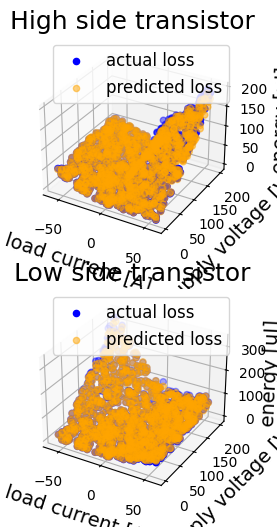

In [37]:
# plot energy over current and predict the curve as well
df_raw_VI = pd.read_csv(f'./data/GS66516T_onlyRG.csv', sep=';')[x_names + y_names]

# filter data for energies higher than 10nJ and smaller than 500uJ
df_VI = df_raw_VI[(df_raw_VI.energy_high < 500e-6) & (df_raw_VI.energy_high > 10e-9) & (df_raw_VI.energy_low < 500e-6) & (df_raw_VI.energy_low > 10e-9)].dropna()

df_pred_VI = predict(df_VI[x_names])

# Erstelle eine Figur mit zwei Subplots
fig = plt.figure(figsize=(8, 10))

# Erster 3D-Scatter-Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(df_VI['rgon'], df_VI['rgoff'], df_VI['energy_high']*1e6, c='b', marker='o', label='actual loss')
ax1.scatter(df_VI['rgon'], df_VI['rgoff']*200, df_pred_VI['energy_high']*1e6, c='orange', marker='o',label='predicted loss', alpha=.5)
ax1.set_title('High side transistor')
ax1.set_xlabel('RG on [Ohm]')
ax1.xaxis.labelpad=-0.9 # <- change the value here
ax1.set_ylabel('RG off [Ohm]')
ax1.yaxis.labelpad=-0.5 # <- change the value here
ax1.set_zlabel('energy [uJ]')
ax2.zaxis.labelpad=-0.5 # <- change the value here
ax1.legend()

# Zweiter 3D-Scatter-Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(df_VI['iload_ratio']*60, df_VI['vsup_ratio']*200, df_VI['energy_low']*1e6, c='b', marker='o',label='actual loss')
ax2.scatter(df_VI['iload_ratio']*60, df_VI['vsup_ratio']*200, df_pred_VI['energy_low']*1e6, c='orange', marker='o', alpha=.5, label='predicted loss')
ax2.set_title('Low side transistor')
ax1.set_xlabel('RG on [Ohm]')
ax1.xaxis.labelpad=-0.9 # <- change the value here
ax1.set_ylabel('RG off [Ohm]')
ax2.yaxis.labelpad=-0.5 # <- change the value here
ax2.set_zlabel('energy [uJ]', rotation=90)
ax2.zaxis.labelpad=-0.7 # <- change the value here
ax2.legend()



# Layout anpassen und Plot anzeigen
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)
plt.show()
